# Case 1

## Import libraries

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import KNNImputer

import scipy . linalg as lng # linear algebra from scipy library
from sklearn import preprocessing as preproc # preprocessing from sklearn library

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

## Load data

In [66]:
# Path to the data files
data_path_1 = '../data/case1Data.csv'
data_path_2 = '../data/case1Data_Xnew.csv'

# Load the data into a numpy array
data_np = np.loadtxt(data_path_1, delimiter=',', skiprows=1)
data_np_new = np.loadtxt(data_path_2, delimiter=',', skiprows=1)

# Print the shape of the data in the numpy array
print(data_np.shape) # 100 rows and 101 columns (100 features and 1 target)
print(data_np_new.shape) # 1000 rows and 100 columns (100 features and no target)

# Create a pandas dataframe and use the first row as the column names
data_pd = pd.read_csv(data_path_1, sep=',', header=0)
data_pd_new = pd.read_csv(data_path_2, sep=',', header=0)

# Print the shape of the data in the pandas dataframe
print(data_pd.shape)
print(data_pd_new.shape)

(100, 101)
(1000, 100)
(100, 101)
(1000, 100)


## Handling missing values

Possible methods:
- Drop rows
- Imputation: Mean, Median, Mode
- Interolation: Linear, Quadratic
- K-Nearest Neighbors (KNN)

In [67]:
# Use KNNImputer from scikit-learn to impute the missing values in the data with the mean of the k-nearest neighbors

# class sklearn.impute.KNNImputer(*, missing_values=nan, n_neighbors=5, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False, keep_empty_features=False)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

# Fit the imputer on the data and transform the data
data_imputed = imputer.fit_transform(data_pd)
data_new_imputed = imputer.fit_transform(data_pd_new)

# Round the last 5 columns to a whole number
data_imputed[:, -5:] = np.round(data_imputed[:, -5:])
data_new_imputed[:, -5:] = np.round(data_new_imputed[:, -5:])

# Convert back into a pandas dataframe
data_imputed = pd.DataFrame(data_imputed, columns=data_pd.columns)
data_new_imputed = pd.DataFrame(data_new_imputed, columns=data_pd_new.columns)

# Print the shape of the imputed data
#print(data_imputed.shape)
#print(data_new_imputed.shape)

In [68]:
# One-hot encode only the last 5 columns of the imputed data
data_imputed = pd.get_dummies(data_imputed, columns=data_imputed.columns[-5:], dtype=int)

# Convert the numerical columns to float before applying standardization
data_imputed.iloc[:, :-36] = data_imputed.iloc[:, :-36].astype(float)

# Standardizing the numerical features and targets: z = (x - u) / sd
scaler = preproc.StandardScaler()
data_imputed.iloc[:, :-36] = scaler.fit_transform(data_imputed.iloc[:, :-36])

# Save the imputed data to a csv file
np.savetxt('../data/case1Data_imputed.csv', data_imputed, delimiter=',')
np.savetxt('../data/case1Data_Xnew_imputed.csv', data_new_imputed, delimiter=',')

# First column is the target variable
y = data_imputed.iloc[:, 0]

# X is the feature matrix (all columns except the first)
X = data_imputed.iloc[:, 1:]

# Number of observations
[n, p] = X.shape

## Building models

OLS fra Anton:

In [69]:
def ols_solver(X, y):
    betas, res, rnk, s = lng.lstsq(X, y)
    
    return betas, res, rnk, s

# Include offset / intercept
off = np.ones(n)
X = np.c_[off, X]

[n, p] = X.shape

#Split into train and test
X_train = X[:50, :]
X_test = X[50:, :]
y_train = y[:50]
y_test = y[50:]

#Estimate the model parameters
betas, residuals, rnk, s = ols_solver(X_train, y_train)

#Calculate y_hat
y_hat = X_test @ betas

res_solv_man = (y_test - y_hat) ** 2    
mse = np.mean(res_solv_man)

print(f'mse from lstsq: {mse}') # lng.lstsq returns sum of squared residuals, so we divide by num of obs to get mean
rss = np.sum(res_solv_man)
print(f'RSS: {rss}')
tss = np.sum((y - np.mean(y))** 2)
print(f'TSS: {tss}')
r2 = (1 - rss / tss) * 100
print(f'R2: {r2}')

mse from lstsq: 0.438024170631861
RSS: 21.90120853159305
TSS: 100.0
R2: 78.09879146840694


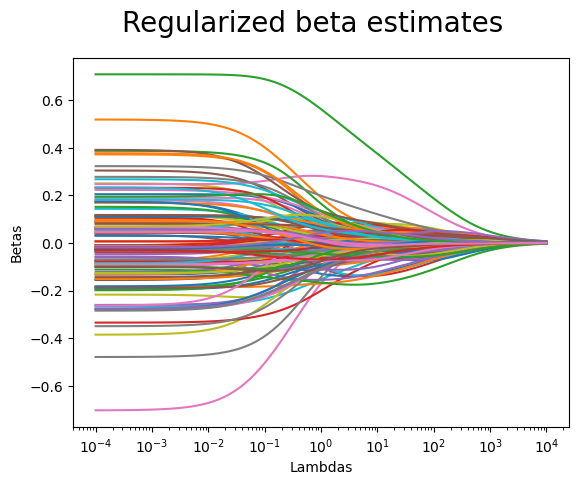

In [70]:
def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas
k = 100; # try k values of lambda
lambdas = np.logspace(-4, 4, k)

betas = np.zeros((p,k))

for i in range(k):
    betas[:, i] = ridgeMulti(X, lambdas[i], p, y)
    
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle("Regularized beta estimates", fontsize=20)
plt.show()


In [71]:
# Perform RidgeCV with 10-fold cross-validation
ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=False, cv=10)
ridge_cv.fit(X, y)

# Optimal lambda
lambda_OP = ridge_cv.alpha_

#print optimal lambda
print(f'Optimal lambda: {lambda_OP}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Optimal lambda: 12.328467394420684


In [72]:
# Estimate mse with optimal lambda
y_hat = ridge_cv.predict(X_test)
mse = np.mean((y_test - y_hat) ** 2)
print(f'mse from RidgeCV: {mse}')

mse from RidgeCV: 0.0354345757863044


## Random Forest